In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import json
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.dates import DateFormatter

import matplotlib
# matplotlib.use('Agg')  # Use non-interactive backend for matplotlib to save memory

from utils import print_log

In [2]:
expt_datetime_dict = {
    ("discrete", "0.0"): datetime(2025, 8, 13, 23, 23, 31),
    ("discrete", "0.5"): datetime(2025, 8, 14, 2, 5, 26),
    ("discrete", "1.0"): datetime(2025, 8, 14, 4, 46, 19),
    ("continuous", "0.0"): datetime(2025, 8, 11, 2, 46, 31),
    ("continuous", "0.5"): datetime(2025, 8, 11, 4, 45, 55),
    ("continuous", "1.0"): datetime(2025, 8, 11, 6, 42, 39),
}

In [3]:
expt_folders = {
    k: Path("experiments") / (v.strftime("%Y%m%d_%H%M%S") + "_action_" + k[0] + "_reward_lambda_" + k[1]) for k, v in expt_datetime_dict.items()
}

# check if all folders exist
for folder in expt_folders.values():
    if not folder.exists():
        print_log(f"Experiment folder {folder} does not exist. Please check the experiment datetime and action type.")
        raise FileNotFoundError(f"Experiment folder {folder} does not exist.")
    else:
        print_log(f"Experiment folder {folder} exists.")
    
expt_train_folders = {
    k: v / ("logs_train") for k, v in expt_folders.items()
}

[2025-08-25 18:52:46:795] Experiment folder experiments/20250813_232331_action_discrete_reward_lambda_0.0 exists.
[2025-08-25 18:52:46:795] Experiment folder experiments/20250814_020526_action_discrete_reward_lambda_0.5 exists.
[2025-08-25 18:52:46:795] Experiment folder experiments/20250814_044619_action_discrete_reward_lambda_1.0 exists.
[2025-08-25 18:52:46:795] Experiment folder experiments/20250811_024631_action_continuous_reward_lambda_0.0 exists.
[2025-08-25 18:52:46:795] Experiment folder experiments/20250811_044555_action_continuous_reward_lambda_0.5 exists.
[2025-08-25 18:52:46:795] Experiment folder experiments/20250811_064239_action_continuous_reward_lambda_1.0 exists.


In [4]:
output_folder = Path("experiments_graphs") / "multi_episodes"

if not output_folder.exists():
    output_folder.mkdir(parents=True)

In [5]:
def load_all_training_episode_data(expt_train_folders):
    """
    Load episode information data from all experiment training folders.
    
    Args:
        expt_train_folders: dict with keys (action_space, lambda_value) and values as Path objects
                           to training folders containing episode_info subdirectories
    
    Returns:
        dict: Same keys as input, values are tuples of (episode_metadata_df, episode_info_dfs)
    """
    all_results = {}
    
    # Helper function to flatten nested dictionaries
    def flatten(d, parent_key='', sep='_'):
        items = []
        for k, v in d.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            if isinstance(v, dict):
                items.extend(flatten(v, new_key, sep=sep).items())
            else:
                items.append((new_key, v))
        return dict(items)
    
    for key, expt_phrase_folder in expt_train_folders.items():
        print_log(f"Loading data for experiment {key}: {expt_phrase_folder}")
        
        # Load episode information data
        episode_info_folder = expt_phrase_folder / "episode_info"
        if episode_info_folder.exists():
            episode_info_files = sorted(list(episode_info_folder.glob("*.json")))
            episode_info_dfs = []
            episode_metadata_list = []

            print_log(f"Loading {len(episode_info_files)} episode files for {key}...")
            
            for file in episode_info_files:
                with open(file, "r") as f:
                    episode_info = json.load(f)
                    
                    # Extract episode data and metadata (support new format)
                    if isinstance(episode_info, dict) and 'episode_data' in episode_info:
                        # New format with metadata
                        episode_data = episode_info['episode_data']
                        metadata = episode_info.get('metadata', {})
                        df = pd.DataFrame(episode_data)

                        metadata = flatten(metadata)  # Flatten metadata dictionary
                        
                        # Store metadata for analysis
                        episode_metadata_list.append({
                            'episode_file': file.name,
                            **metadata
                        })

                    # Add episode number column
                    df['episode'] = int(file.stem.split('_')[1])
                    df['episode_index'] = len(episode_info_dfs)                     # Add episode index for plotting
                    df['episode_data_idx'] = metadata.get('episode_data_idx', 0)    # Add episode data index
                    
                    # Convert datetime strings to datetime objects
                    if 'datetime' in df.columns:
                        df['datetime'] = pd.to_datetime(df['datetime'], format='ISO8601')
                    
                    # Temporary fix: shift some columns forward by one timestep
                    shift_columns = ['grid_load (W)', 'action (kW)', 'battery_action (kW)', 'reward', 
                                   'f_signal', 'g_signal', 'f_signal-predicted_mean', 
                                   'f_signal-predicted_log_var', 'f_signal-target', 'f_signal-loss']
                    
                    for col in shift_columns:
                        if col in df.columns:
                            df[col] = df[col].shift(-1)
                    
                    # Remove the last row for each episode
                    df = df[:-1]

                    # temporary fix for grid load calculation (once)
                    df['grid_load (W)'] = df['user_load (W)'] + df['battery_action (kW)'] * 1000
                    
                    episode_info_dfs.append(df)

            # Create episode metadata DataFrame for curriculum analysis
            episode_metadata_df = pd.DataFrame(episode_metadata_list)
            
            print_log(f"Loaded {len(episode_info_dfs)} episodes for {key}")
            print_log(f"Episode metadata shape for {key}: {episode_metadata_df.shape}")
            
            all_results[key] = (episode_metadata_df, episode_info_dfs)
            
        else:
            print_log(f"Episode info folder {episode_info_folder} does not exist for {key}.")
            all_results[key] = (None, None)
    
    return all_results

In [6]:
# Load all training episode data from experiment folders
all_training_data = load_all_training_episode_data(expt_train_folders)

# Display summary of loaded data
for key, (episode_metadata_df, episode_info_dfs) in all_training_data.items():
    if episode_info_dfs is not None:
        print_log(f"Experiment {key}: {len(episode_info_dfs)} episodes loaded")
    else:
        print_log(f"Experiment {key}: No data found")

[2025-08-25 18:52:46:820] Loading data for experiment ('discrete', '0.0'): experiments/20250813_232331_action_discrete_reward_lambda_0.0/logs_train
[2025-08-25 18:52:46:824] Loading 805 episode files for ('discrete', '0.0')...
[2025-08-25 18:52:52:150] Loaded 805 episodes for ('discrete', '0.0')
[2025-08-25 18:52:52:150] Episode metadata shape for ('discrete', '0.0'): (805, 9)
[2025-08-25 18:52:52:150] Loading data for experiment ('discrete', '0.5'): experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train
[2025-08-25 18:52:52:154] Loading 805 episode files for ('discrete', '0.5')...
[2025-08-25 18:53:00:291] Loaded 805 episodes for ('discrete', '0.5')
[2025-08-25 18:53:00:291] Episode metadata shape for ('discrete', '0.5'): (805, 9)
[2025-08-25 18:53:00:291] Loading data for experiment ('discrete', '1.0'): experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train
[2025-08-25 18:53:00:294] Loading 805 episode files for ('discrete', '1.0')...
[2025-08-25 1

Also load the training MI and incurred extra cost for quick overview of the selected episodes

In [7]:
# copied from expt_results_cross_models_privacy_protection.ipynb

def load_all_training_MI(expt_train_folders):
    """
    Load MI on training data from all experiment training folders.
    
    Args:
        expt_train_folders: dict with keys (action_space, lambda_value) and values as Path objects
                           to training folders containing mutual_information_per_episode.pkl files

    Returns:
        dict: Same keys as input, values are DataFrames containing MI on training data
    """

    all_results = {}
    
    for key, expt_train_folder in expt_train_folders.items():
        print_log(f"Loading MI on training data for experiment {key}: {expt_train_folder}")

        # Load MI on training data
        mi_on_training_data_path = expt_train_folder / "graphs" / "per_episode_psd" / "mutual_information_per_episode.pkl"

        if mi_on_training_data_path.exists():
            with open(mi_on_training_data_path, "rb") as f:
                mi_on_training_data_df = pd.read_pickle(f)
                print_log(f"Loaded MI on training data for {key}: {len(mi_on_training_data_df)} training steps")
                print_log(f"MI on training data DataFrame shape for {key}: {mi_on_training_data_df.shape}")
                all_results[key] = mi_on_training_data_df
        else:
            print_log(f"MI on training data file {mi_on_training_data_path} does not exist for {key}.")
            all_results[key] = None
    
    return all_results

def load_all_training_extra_cost(expt_train_folders):
    """
    Load extra cost on training data from all experiment training folders.

    Args:
        expt_train_folders: dict with keys (action_space, lambda_value) and values as Path objects
                           to training folders containing extra_cost_per_episode.pkl files

    Returns:
        dict: Same keys as input, values are DataFrames containing extra cost on training data
    """

    all_results = {}
    
    for key, expt_train_folder in expt_train_folders.items():
        print_log(f"Loading MI on training data for experiment {key}: {expt_train_folder}")

        # Load MI on training data
        extra_cost_on_training_data_path = expt_train_folder / "graphs" / "per_episode_psd" / "extra_cost_per_episode.pkl"

        if extra_cost_on_training_data_path.exists():
            with open(extra_cost_on_training_data_path, "rb") as f:
                extra_cost_on_training_data_df = pd.read_pickle(f)
                print_log(f"Loaded extra cost on training data for {key}: {len(extra_cost_on_training_data_df)} training steps")
                print_log(f"Extra cost on training data DataFrame shape for {key}: {extra_cost_on_training_data_df.shape}")
                all_results[key] = extra_cost_on_training_data_df
        else:
            print_log(f"Extra cost on training data file {extra_cost_on_training_data_path} does not exist for {key}.")
            all_results[key] = None
    
    return all_results

In [8]:
# Load all MI data from experiment folders
all_training_MI = load_all_training_MI(expt_train_folders)

# Display summary of loaded data
for key, mi_on_training_data_df in all_training_MI.items():
    if mi_on_training_data_df is not None:
        print_log(f"Experiment {key}: {len(mi_on_training_data_df)} training steps loaded")
        if len(mi_on_training_data_df) > 0:
            print_log(f"  Columns: {list(mi_on_training_data_df.columns)}")
            print_log(f"  Training steps range: {mi_on_training_data_df.index.min()} to {mi_on_training_data_df.index.max()}")
    else:
        print_log(f"Experiment {key}: No MI on training data found")

# Load all extra cost data from experiment folders
all_training_extra_cost = load_all_training_extra_cost(expt_train_folders)

# Display summary of loaded data
for key, extra_cost_on_training_data_df in all_training_extra_cost.items():
    if extra_cost_on_training_data_df is not None:
        print_log(f"Experiment {key}: {len(extra_cost_on_training_data_df)} training steps loaded")
        if len(extra_cost_on_training_data_df) > 0:
            print_log(f"  Columns: {list(extra_cost_on_training_data_df.columns)}")
            print_log(f"  Training steps range: {extra_cost_on_training_data_df.index.min()} to {extra_cost_on_training_data_df.index.max()}")
    else:
        print_log(f"Experiment {key}: No extra cost on training data found")

[2025-08-25 18:53:23:722] Loading MI on training data for experiment ('discrete', '0.0'): experiments/20250813_232331_action_discrete_reward_lambda_0.0/logs_train
[2025-08-25 18:53:23:722] Loaded MI on training data for ('discrete', '0.0'): 805 training steps
[2025-08-25 18:53:23:722] MI on training data DataFrame shape for ('discrete', '0.0'): (805, 5)
[2025-08-25 18:53:23:722] Loading MI on training data for experiment ('discrete', '0.5'): experiments/20250814_020526_action_discrete_reward_lambda_0.5/logs_train
[2025-08-25 18:53:23:723] Loaded MI on training data for ('discrete', '0.5'): 805 training steps
[2025-08-25 18:53:23:723] MI on training data DataFrame shape for ('discrete', '0.5'): (805, 5)
[2025-08-25 18:53:23:723] Loading MI on training data for experiment ('discrete', '1.0'): experiments/20250814_044619_action_discrete_reward_lambda_1.0/logs_train
[2025-08-25 18:53:23:723] Loaded MI on training data for ('discrete', '1.0'): 805 training steps
[2025-08-25 18:53:23:723] MI

In [9]:
list(all_training_MI.keys())

[('discrete', '0.0'),
 ('discrete', '0.5'),
 ('discrete', '1.0'),
 ('continuous', '0.0'),
 ('continuous', '0.5'),
 ('continuous', '1.0')]

Multi-episode on "continuous" vs "discrete" on the same $\lambda$ value

In [10]:
def plot_cross_action_space_episodes_grid(all_training_data, lambda_value, episode_interval=50, save_path=None, save_dir=None, use_datetime=False, show=True, include_curriculum_info=True):
    """
    Create a grid plot comparing episodes across different action spaces (continuous vs discrete) for the same lambda value.
    
    Args:
        all_training_data: Dictionary with keys (action_space, lambda_value) and values (episode_metadata_df, episode_info_dfs)
        lambda_value: String lambda value to compare (one of "0.0", "0.5", "1.0")
        episode_interval: Interval between episodes to plot (default: 50)
        save_path: Optional specific path to save the figure (overrides auto-generated filename)
        save_dir: Directory to save the figure (used with auto-generated filename if save_path is None)
        use_datetime: Whether to use datetime for x-axis (default is False)
        show: Whether to display the plot
        include_curriculum_info: Whether to include curriculum information in titles
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    # Validate lambda value
    valid_lambdas = ["0.0", "0.5", "1.0"]
    if lambda_value not in valid_lambdas:
        raise ValueError(f"lambda_value must be one of {valid_lambdas}, got {lambda_value}")
    
    # Get data for continuous and discrete action spaces with the specified lambda
    continuous_key = ("continuous", lambda_value)
    discrete_key = ("discrete", lambda_value)
    
    continuous_data = all_training_data.get(continuous_key)
    discrete_data = all_training_data.get(discrete_key)
    
    if continuous_data is None or continuous_data[1] is None:
        print_log(f"No continuous data found for lambda={lambda_value}")
        return None
    
    if discrete_data is None or discrete_data[1] is None:
        print_log(f"No discrete data found for lambda={lambda_value}")
        return None
    
    continuous_metadata, continuous_episodes = continuous_data
    discrete_metadata, discrete_episodes = discrete_data
    
    # Determine episodes to plot based on interval
    max_episodes = min(len(continuous_episodes), len(discrete_episodes))
    episode_indices = list(range(0, max_episodes, episode_interval))
    
    # Limit to reasonable number of subplots (max 4 episodes per row)
    if len(episode_indices) > 4:
        episode_indices = episode_indices[:4]
    
    n_episodes = len(episode_indices)
    if n_episodes == 0:
        print_log("No episodes to plot")
        return None
    
    print_log(f"Plotting {n_episodes} episodes at indices: {episode_indices}")
    
    # Generate auto filename if save_path is not provided
    if save_path is None and save_dir is not None:
        episode_range = f"{episode_indices[0]:04d}_{episode_indices[-1]:04d}"
        filename = f"cross_action_space_episodes_lambda_{lambda_value}_episodes_{episode_range}_interval_{episode_interval}.svg"
        save_path = save_dir / filename
        print_log(f"Auto-generated filename: {filename}")
    
    # Create figure with 2 rows (continuous, discrete) and n_episodes columns
    fig, axes = plt.subplots(2, n_episodes, figsize=(6 * n_episodes, 10), dpi=150)
    
    # Handle single episode case
    if n_episodes == 1:
        axes = axes.reshape(2, 1)
    
    # Define colors and styling
    colors = {
        'user_load': 'blue',
        'grid_load': 'orange',
        'soc_increase': 'green',
        'soc_decrease': 'red',
        'soc_constant': 'blue'
    }
    
    for col_idx, episode_idx in enumerate(episode_indices):
        # Plot continuous action space (top row)
        ax_cont = axes[0, col_idx]
        continuous_episode = continuous_episodes[episode_idx]
        algo_name_cont = "PPO-MI"
        ax_cont_twin = plot_single_episode(ax_cont, continuous_episode, use_datetime, include_curriculum_info, 
                          continuous_metadata, f"{algo_name_cont} λ={lambda_value}", colors, episode_idx)
        
        # Plot discrete action space (bottom row)
        ax_disc = axes[1, col_idx]
        discrete_episode = discrete_episodes[episode_idx]
        algo_name_disc = "DDQL-MI"
        ax_disc_twin = plot_single_episode(ax_disc, discrete_episode, use_datetime, include_curriculum_info,
                          discrete_metadata, f"{algo_name_disc} λ={lambda_value}", colors, episode_idx)
        
        # Set x-axis label only for bottom row
        if use_datetime and 'datetime' in continuous_episode.columns:
            ax_disc.set_xlabel('Time', fontsize=10)
        else:
            ax_disc.set_xlabel('Time Steps', fontsize=10)
        
        # Add legend only to first column
        if col_idx == 0:
            ax_cont.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
            ax_disc.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
            
            # Add SOC legend to first column using existing twin axes
            legend_elements = [Patch(facecolor='green', label='SOC ↑'),
                             Patch(facecolor='red', label='SOC ↓'),
                             Patch(facecolor='blue', label='SOC →')]
            ax_cont_twin.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0.8), loc='upper left', fontsize=8)
            ax_disc_twin.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0.8), loc='upper left', fontsize=8)
    
    plt.suptitle(f'Multi-Episode Comparison: PPO-MI vs DDQL-MI (λ={lambda_value})', 
                 fontsize=14, y=0.98)
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print_log(f"Plot saved to: {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close(fig)
        plt.close('all')
    
    return fig, episode_indices


def plot_single_episode(ax, episode_df, use_datetime, include_curriculum_info, metadata_df, action_space_label, colors, episode_idx):
    """
    Helper function to plot a single episode on given axis
    
    Returns:
        ax2: The twin axis used for SOC plotting (for legend placement)
    """
    # Determine x-axis values
    if use_datetime and 'datetime' in episode_df.columns:
        x_values = episode_df['datetime']
    else:
        x_values = range(len(episode_df))
    
    # Plot user load and grid load
    ax.plot(x_values, episode_df['user_load (W)'], label='User Load', 
            color=colors['user_load'], linewidth=2, alpha=0.8)
    ax.plot(x_values, episode_df['grid_load (W)'], label='Grid Load', 
            color=colors['grid_load'], linewidth=2, alpha=0.6)
    
    # Plot SOC on secondary y-axis with color coding
    ax2 = ax.twinx()
    soc_values = episode_df['battery_soc (kWh)'].values
    soc_changes = np.diff(soc_values)
    
    # Create color array based on SOC changes
    color_values = []
    for change in soc_changes:
        if change > 1e-6:
            color_values.append(1)    # SOC increases (green)
        elif change < -1e-6:
            color_values.append(-1)   # SOC decreases (red)
        else:
            color_values.append(0)    # No change (blue)
    
    # Create line segments for color coding
    if use_datetime and 'datetime' in episode_df.columns:
        from matplotlib.dates import date2num
        x_numeric = date2num(episode_df['datetime'])
    else:
        x_numeric = np.array(range(len(episode_df)))
    
    # Create line segments for LineCollection
    points = np.array([x_numeric, soc_values]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create LineCollection with custom colormap
    lc = LineCollection(segments, linewidths=2, capstyle='round')
    lc.set_array(np.array(color_values))
    
    # Create custom colormap: red (-1) -> blue (0) -> green (1)
    colors_map = ['red', 'blue', 'green']
    cmap = ListedColormap(colors_map, name='soc_change', N=3)
    
    lc.set_cmap(cmap)
    lc.set_clim(-1, 1)
    
    # Add the line collection to the plot
    ax2.add_collection(lc)
    
    # Get episode information for title
    episode_ittr = episode_df['episode'].iloc[0]
    episode_data_idx = episode_df['episode_data_idx'].iloc[0] if 'episode_data_idx' in episode_df.columns else episode_idx
    
    # Get curriculum information if available
    episode_length_days = 1
    curriculum_phase = None
    
    if include_curriculum_info and metadata_df is not None:
        metadata = metadata_df[metadata_df['episode_training_idx'] == episode_ittr]
        if len(metadata) == 0 and episode_idx < len(metadata_df):
            metadata = metadata_df.iloc[[episode_idx]]
        
        if len(metadata) > 0:
            metadata_row = metadata.iloc[0]
            episode_length_days = metadata_row.get('episode_length_days', 1)
            curriculum_phase = metadata_row.get('curriculum_phase')
    
    # Create title
    if include_curriculum_info and curriculum_phase is not None:
        title = f'{action_space_label}\nEp {episode_data_idx} @ ittr {episode_ittr}\n{episode_length_days}d, Phase {curriculum_phase}'
    elif include_curriculum_info and episode_length_days != 1:
        title = f'{action_space_label}\nEp {episode_data_idx} @ ittr {episode_ittr}\n{episode_length_days} day(s)'
    else:
        title = f'{action_space_label}\nEp {episode_data_idx} @ ittr {episode_ittr}'
    
    ax.set_title(title, fontsize=10)
    ax.set_ylabel('Power (W)', fontsize=9)
    ax2.set_ylabel('SOC (kWh)', fontsize=9)
    
    # Set axis limits
    if use_datetime and 'datetime' in episode_df.columns:
        ax2.set_xlim(episode_df['datetime'].iloc[0], episode_df['datetime'].iloc[-1])
    else:
        ax2.set_xlim(0, len(episode_df)-1)
    ax2.set_ylim(0, soc_values.max() * 1.05)
    
    # Format datetime axis if using datetime
    if use_datetime and 'datetime' in episode_df.columns:
        formatter = DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(formatter)
        ax2.xaxis.set_major_formatter(formatter)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    ax.grid(True, alpha=0.3)
    
    return ax2  # Return the twin axis for potential legend use

[2025-08-25 18:55:32:387] 
[2025-08-25 18:55:32:387] Generating comparison plot for λ = 0.0
[2025-08-25 18:55:32:387] ============================================================
[2025-08-25 18:55:32:387] Plotting 4 episodes at indices: [0, 100, 200, 300]
[2025-08-25 18:55:32:387] Auto-generated filename: cross_action_space_episodes_lambda_0.0_episodes_0000_0300_interval_100.svg
[2025-08-25 18:55:33:759] Plot saved to: experiments_graphs/multi_episodes/cross_action_space_episodes_lambda_0.0_episodes_0000_0300_interval_100.svg


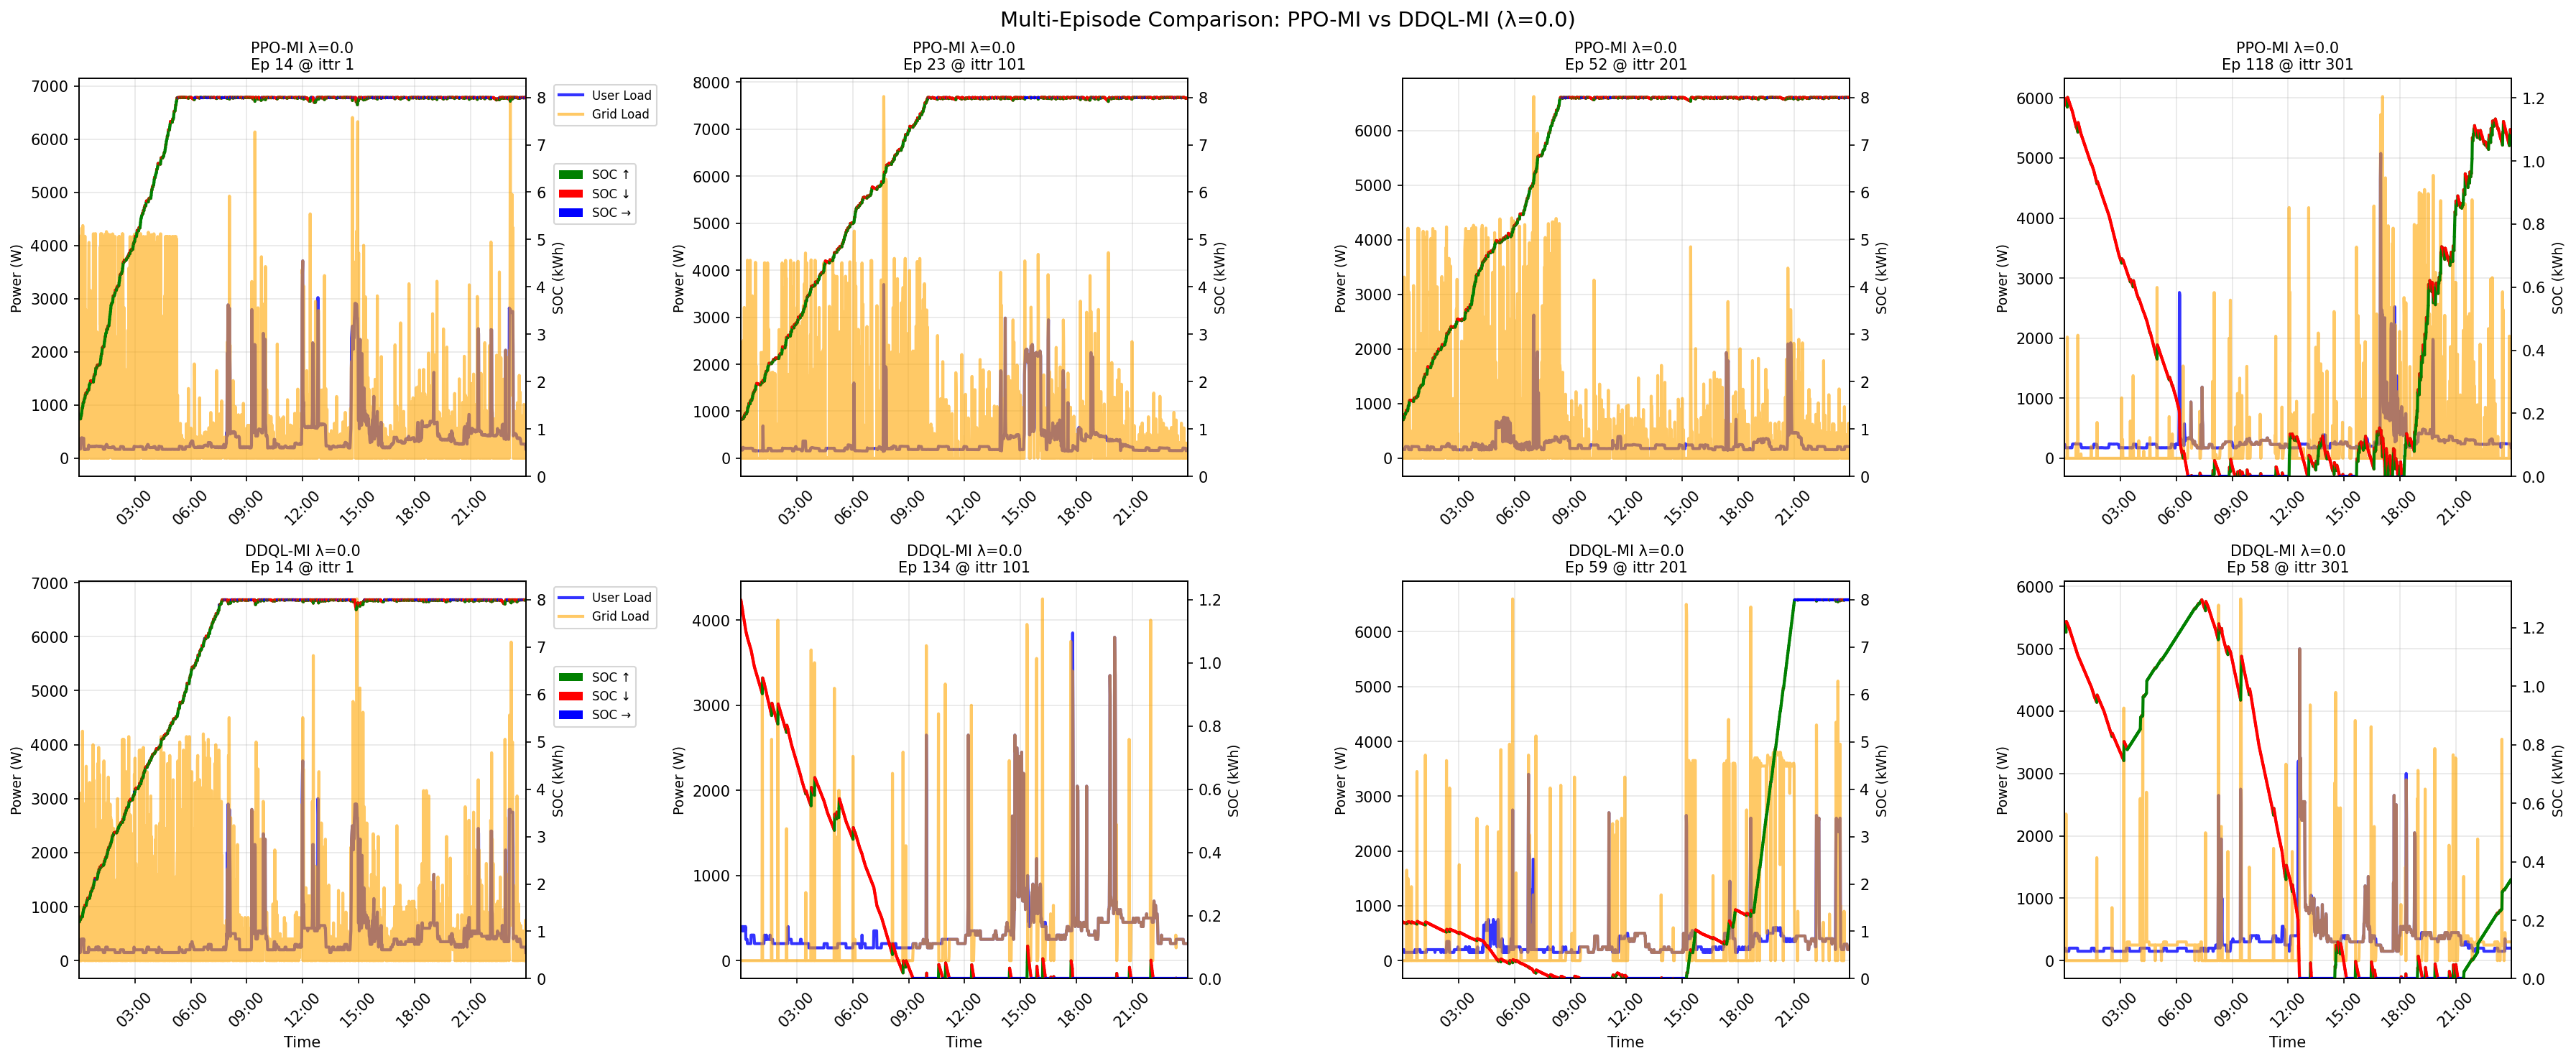

[2025-08-25 18:55:34:472] Successfully generated comparison plot for λ = 0.0
[2025-08-25 18:55:34:472] 
[2025-08-25 18:55:34:472] MI and Extra Cost for Selected Episodes (λ = 0.0)
[2025-08-25 18:55:34:472] ============================================================


Episode                 0         100       200       300
MI (cont)          0.828935  0.308906  0.281858  0.721764
Extra Cost (cont)  0.894257  1.236623  1.212619  0.176583
MI (disc)          0.410059  1.460586  1.056802  1.072847
Extra Cost (disc)  1.035719  0.211388  2.272586  0.275523

MI (cont)  Extra Cost (cont)  MI (disc)  Extra Cost (disc)
count   4.000000           4.000000   4.000000           4.000000
mean    0.535366           0.880020   1.000074           0.948804
std     0.280759           0.494238   0.435393           0.958652
min     0.281858           0.176583   0.410059           0.211388
25%     0.302144           0.714838   0.895117           0.259490
50%     0.515335           1.053438   1.064825           0.655621
75%     0.748557           1.218620   1.169782           1.344936
max     0.828935           1.236623   1.460586           2.272586

[2025-08-25 18:55:34:483] ------------------------------------------------------------
[2025-08-25 18:55:34:483] 
[2025-08-25 18:55:34:483] Generating comparison plot for λ = 0.5
[2025-08-25 18:55:34:483] ============================================================
[2025-08-25 18:55:34:483] Plotting 4 episodes at indices: [0, 100, 200, 300]
[2025-08-25 18:55:34:483] Auto-generated filename: cross_action_space_episodes_lambda_0.5_episodes_0000_0300_interval_100.svg
[2025-08-25 18:55:35:605] Plot saved to: experiments_graphs/multi_episodes/cross_action_space_episodes_lambda_0.5_episodes_0000_0300_interval_100.svg


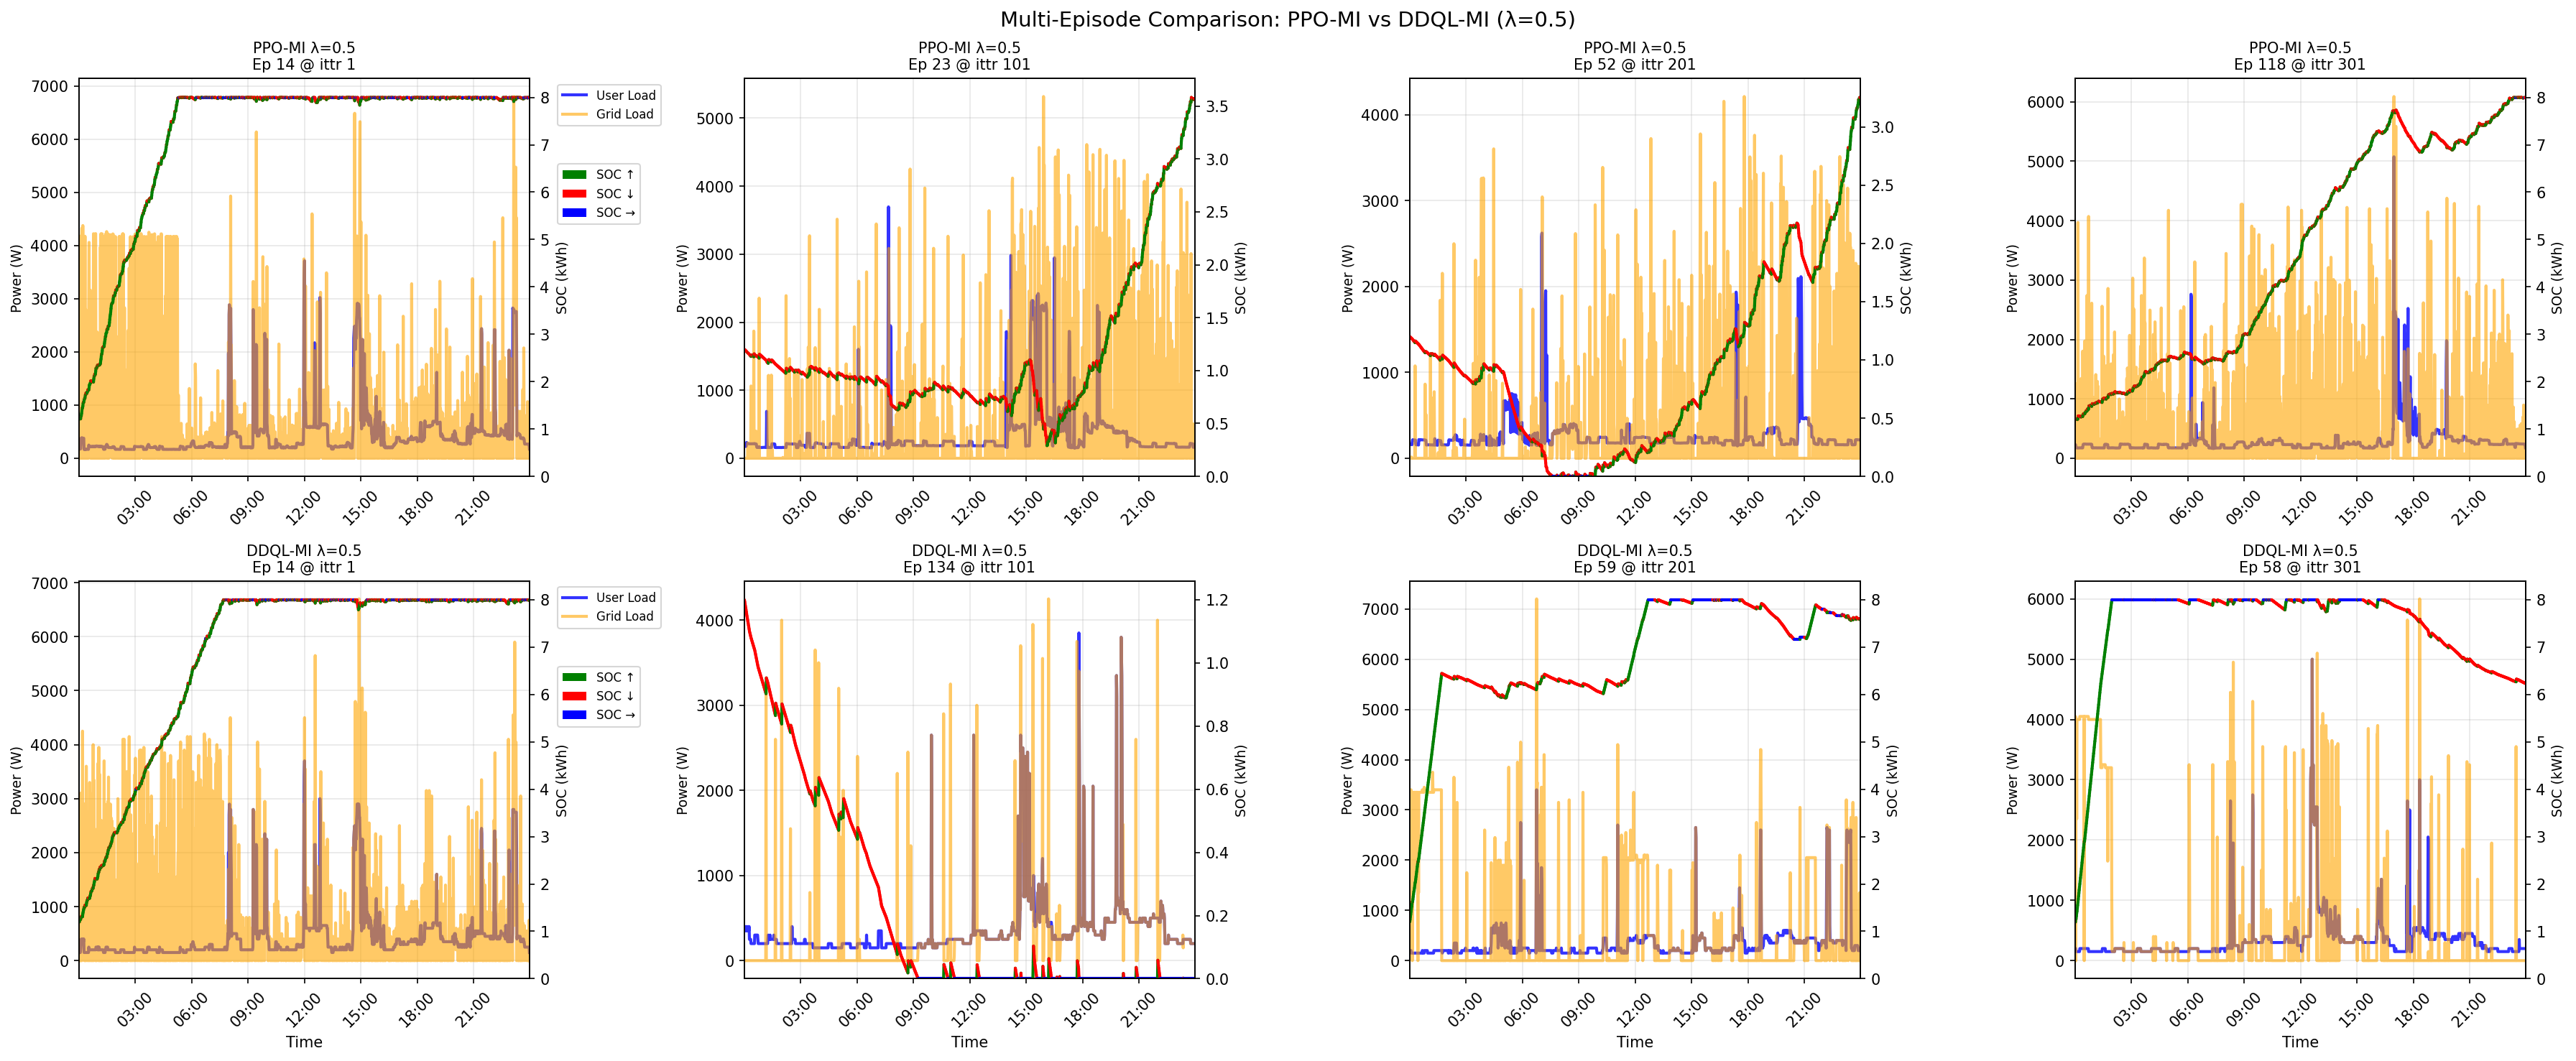

[2025-08-25 18:55:36:317] Successfully generated comparison plot for λ = 0.5
[2025-08-25 18:55:36:317] 
[2025-08-25 18:55:36:317] MI and Extra Cost for Selected Episodes (λ = 0.5)
[2025-08-25 18:55:36:317] ============================================================


Episode                 0         100       200       300
MI (cont)          0.776395  0.046355  0.134965  0.058132
Extra Cost (cont)  0.894257  0.780852  0.794615  1.873510
MI (disc)          0.410059  1.464615  0.816697  0.712171
Extra Cost (disc)  1.035719  0.211388  1.072130  0.367837

MI (cont)  Extra Cost (cont)  MI (disc)  Extra Cost (disc)
count   4.000000           4.000000   4.000000           4.000000
mean    0.253961           1.085808   0.850886           0.671769
std     0.350498           0.527560   0.443998           0.446122
min     0.046355           0.780852   0.410059           0.211388
25%     0.055187           0.791174   0.636643           0.328725
50%     0.096548           0.844436   0.764434           0.701778
75%     0.295322           1.139070   0.978677           1.044822
max     0.776395           1.873510   1.464615           1.072130

[2025-08-25 18:55:36:328] ------------------------------------------------------------
[2025-08-25 18:55:36:328] 
[2025-08-25 18:55:36:328] Generating comparison plot for λ = 1.0
[2025-08-25 18:55:36:328] ============================================================
[2025-08-25 18:55:36:328] Plotting 4 episodes at indices: [0, 100, 200, 300]
[2025-08-25 18:55:36:328] Auto-generated filename: cross_action_space_episodes_lambda_1.0_episodes_0000_0300_interval_100.svg
[2025-08-25 18:55:37:446] Plot saved to: experiments_graphs/multi_episodes/cross_action_space_episodes_lambda_1.0_episodes_0000_0300_interval_100.svg


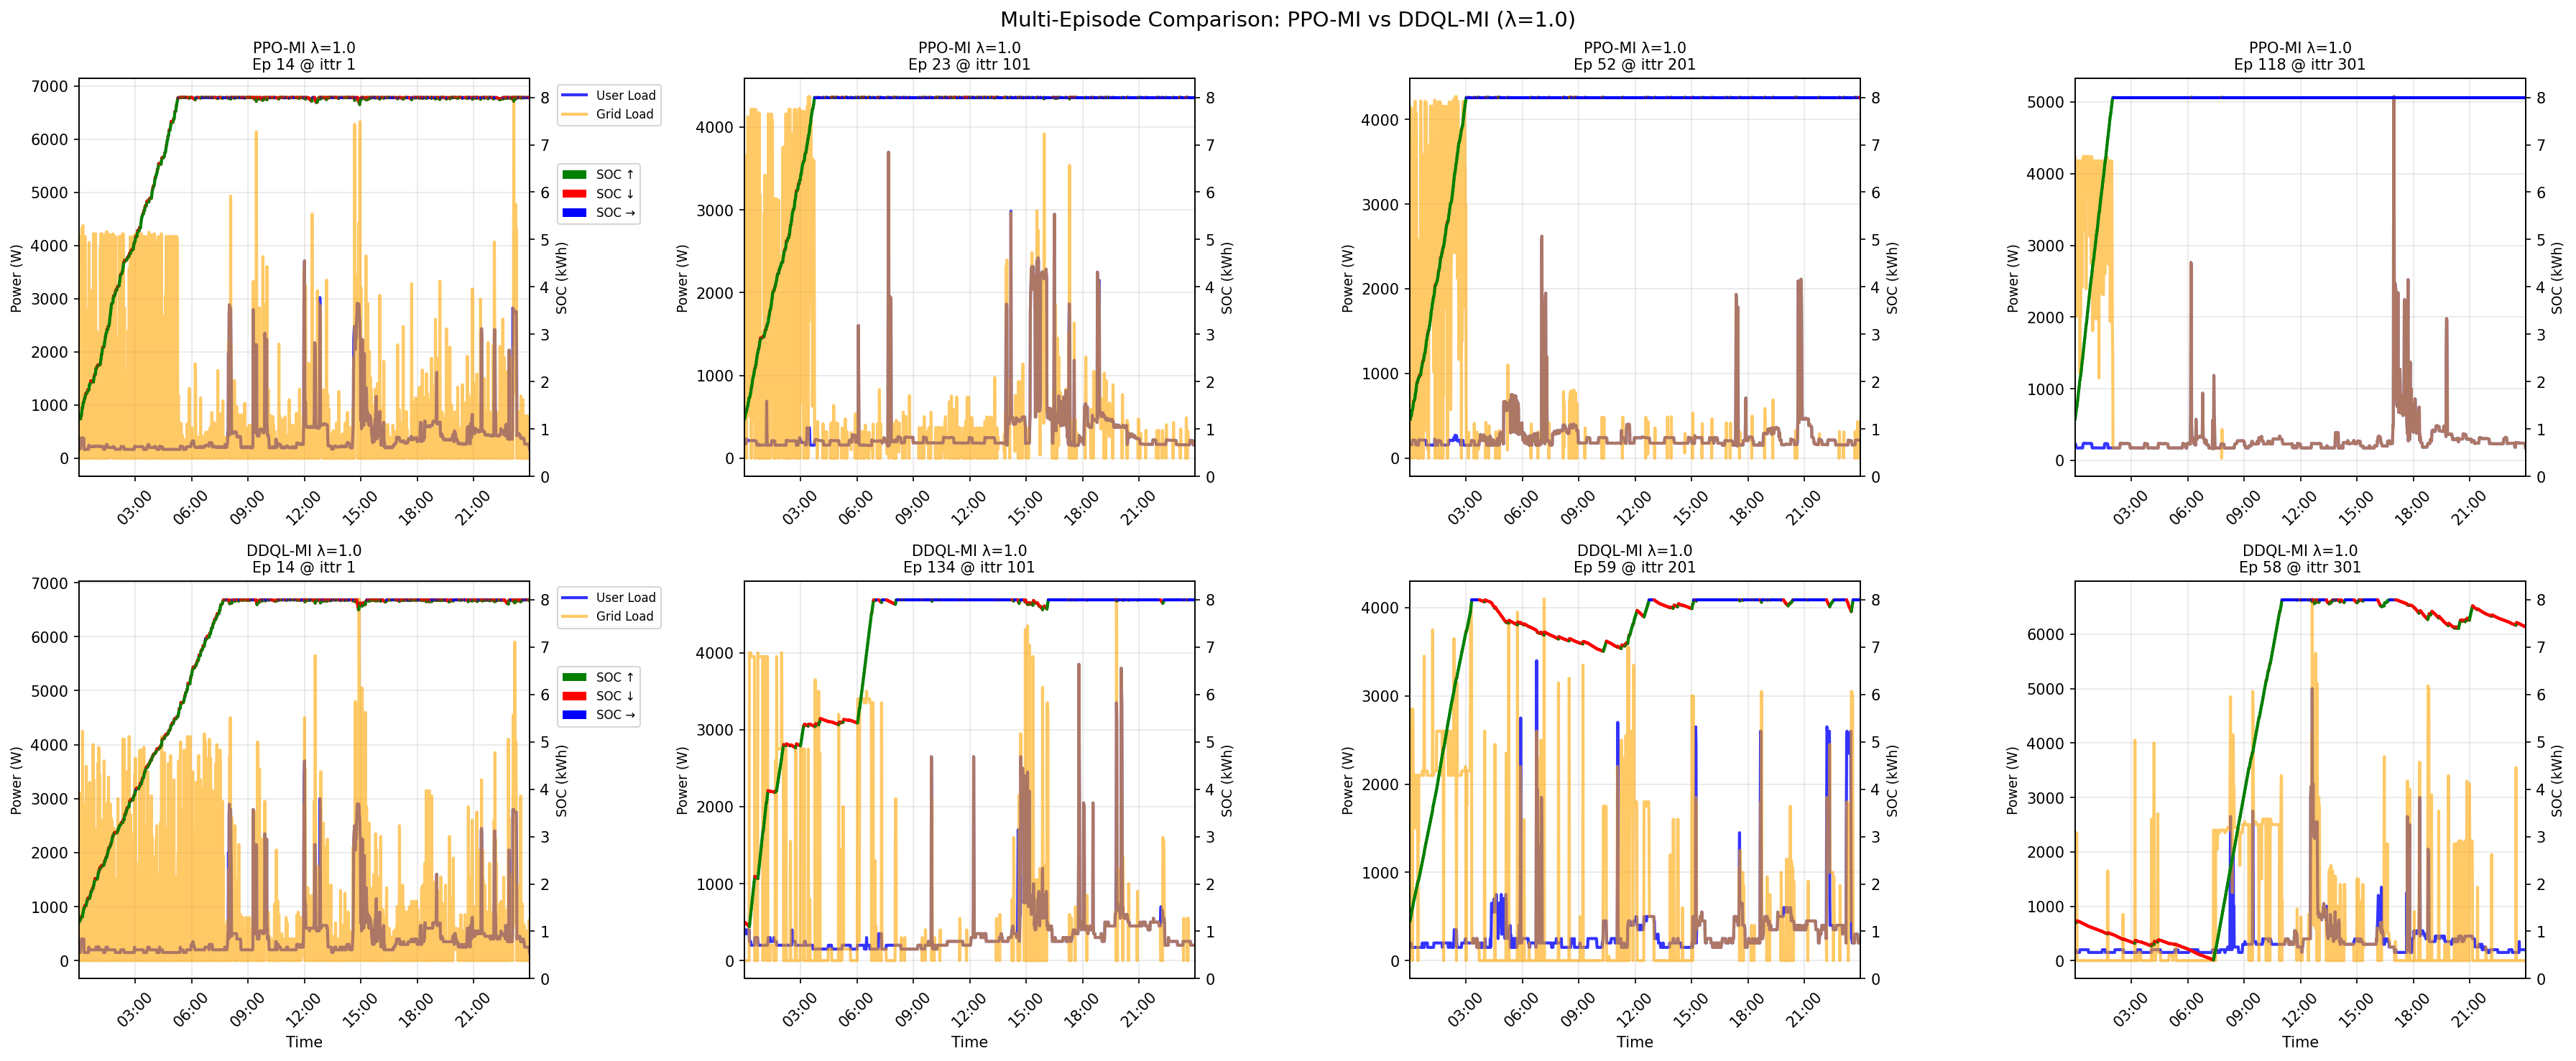

[2025-08-25 18:55:38:134] Successfully generated comparison plot for λ = 1.0
[2025-08-25 18:55:38:134] 
[2025-08-25 18:55:38:134] MI and Extra Cost for Selected Episodes (λ = 1.0)
[2025-08-25 18:55:38:134] ============================================================


Episode                 0         100       200       300
MI (cont)          0.849377  2.807619  3.427707  4.305205
Extra Cost (cont)  0.894257  0.895560  0.894464  0.895560
MI (disc)          0.410059  1.452352  1.144794  0.889527
Extra Cost (disc)  1.035719  0.899236  1.017235  2.048270

MI (cont)  Extra Cost (cont)  MI (disc)  Extra Cost (disc)
count   4.000000           4.000000   4.000000           4.000000
mean    2.847477           0.894960   0.974183           1.250115
std     1.466928           0.000698   0.440891           0.535527
min     0.849377           0.894257   0.410059           0.899236
25%     2.318058           0.894412   0.769660           0.987735
50%     3.117663           0.895012   1.017161           1.026477
75%     3.647082           0.895560   1.221684           1.288857
max     4.305205           0.895560   1.452352           2.048270

[2025-08-25 18:55:38:145] ------------------------------------------------------------


In [12]:
# Execute the cross-action space comparison for each lambda value
lambda_values = ["0.0", "0.5", "1.0"]

for lambda_val in lambda_values:
    print_log(f"\n{'='*60}")
    print_log(f"Generating comparison plot for λ = {lambda_val}")
    print_log(f"{'='*60}")

    _episode_interval = 100 # Plot every 100th episode
    
    # Generate the plot with auto-generated filename
    fig, selected_episodes = plot_cross_action_space_episodes_grid(
        all_training_data=all_training_data,
        lambda_value=lambda_val,
        episode_interval=_episode_interval,  
        save_dir=output_folder,
        use_datetime=True,    # Use datetime for x-axis
        show=True,           # Display the plot
        include_curriculum_info=True
    )
    
    if fig is not None:
        print_log(f"Successfully generated comparison plot for λ = {lambda_val}")
    else:
        print_log(f"Failed to generate plot for λ = {lambda_val} - check data availability")


    # print the MI and incurred extra cost of the selected episodes from the all_training_MI and all_training_extra_cost
    # in a table with two rows and 4 column.
    # where the rows represent the model action space (continuous, discrete)
    # and each column is the selected episode

    print_log(f"\n{'='*60}")
    print_log(f"MI and Extra Cost for Selected Episodes (λ = {lambda_val})")
    print_log(f"{'='*60}")

    results = {
        "Episode": selected_episodes,
        "MI (cont)": [all_training_MI[("continuous", lambda_val)].loc[episode, "mutual_information"] for episode in selected_episodes],
        "Extra Cost (cont)": [all_training_extra_cost[("continuous", lambda_val)].loc[episode, "extra_cost"] for episode in selected_episodes],
        "MI (disc)": [all_training_MI[("discrete", lambda_val)].loc[episode, "mutual_information"] for episode in selected_episodes],
        "Extra Cost (disc)": [all_training_extra_cost[("discrete", lambda_val)].loc[episode, "extra_cost"] for episode in selected_episodes],   
    }

    display(pd.DataFrame(results).set_index("Episode").T)
    display(pd.DataFrame(results).set_index("Episode").describe())

    print_log("-" * 60)

[2025-08-13 16:32:57:198] Generating demo comparison plot for λ = 1.0...
[2025-08-13 16:32:57:198] Plotting 4 episodes at indices: [0, 50, 100, 150]
[2025-08-13 16:32:57:198] Auto-generated filename: cross_action_space_episodes_lambda_1.0_episodes_0000_0150_interval_50.png
[2025-08-13 16:32:59:058] Plot saved to: experiments_graphs/multi_episodes/cross_action_space_episodes_lambda_1.0_episodes_0000_0150_interval_50.png
[2025-08-13 16:32:59:058] Plot saved to: experiments_graphs/multi_episodes/cross_action_space_episodes_lambda_1.0_episodes_0000_0150_interval_50.png


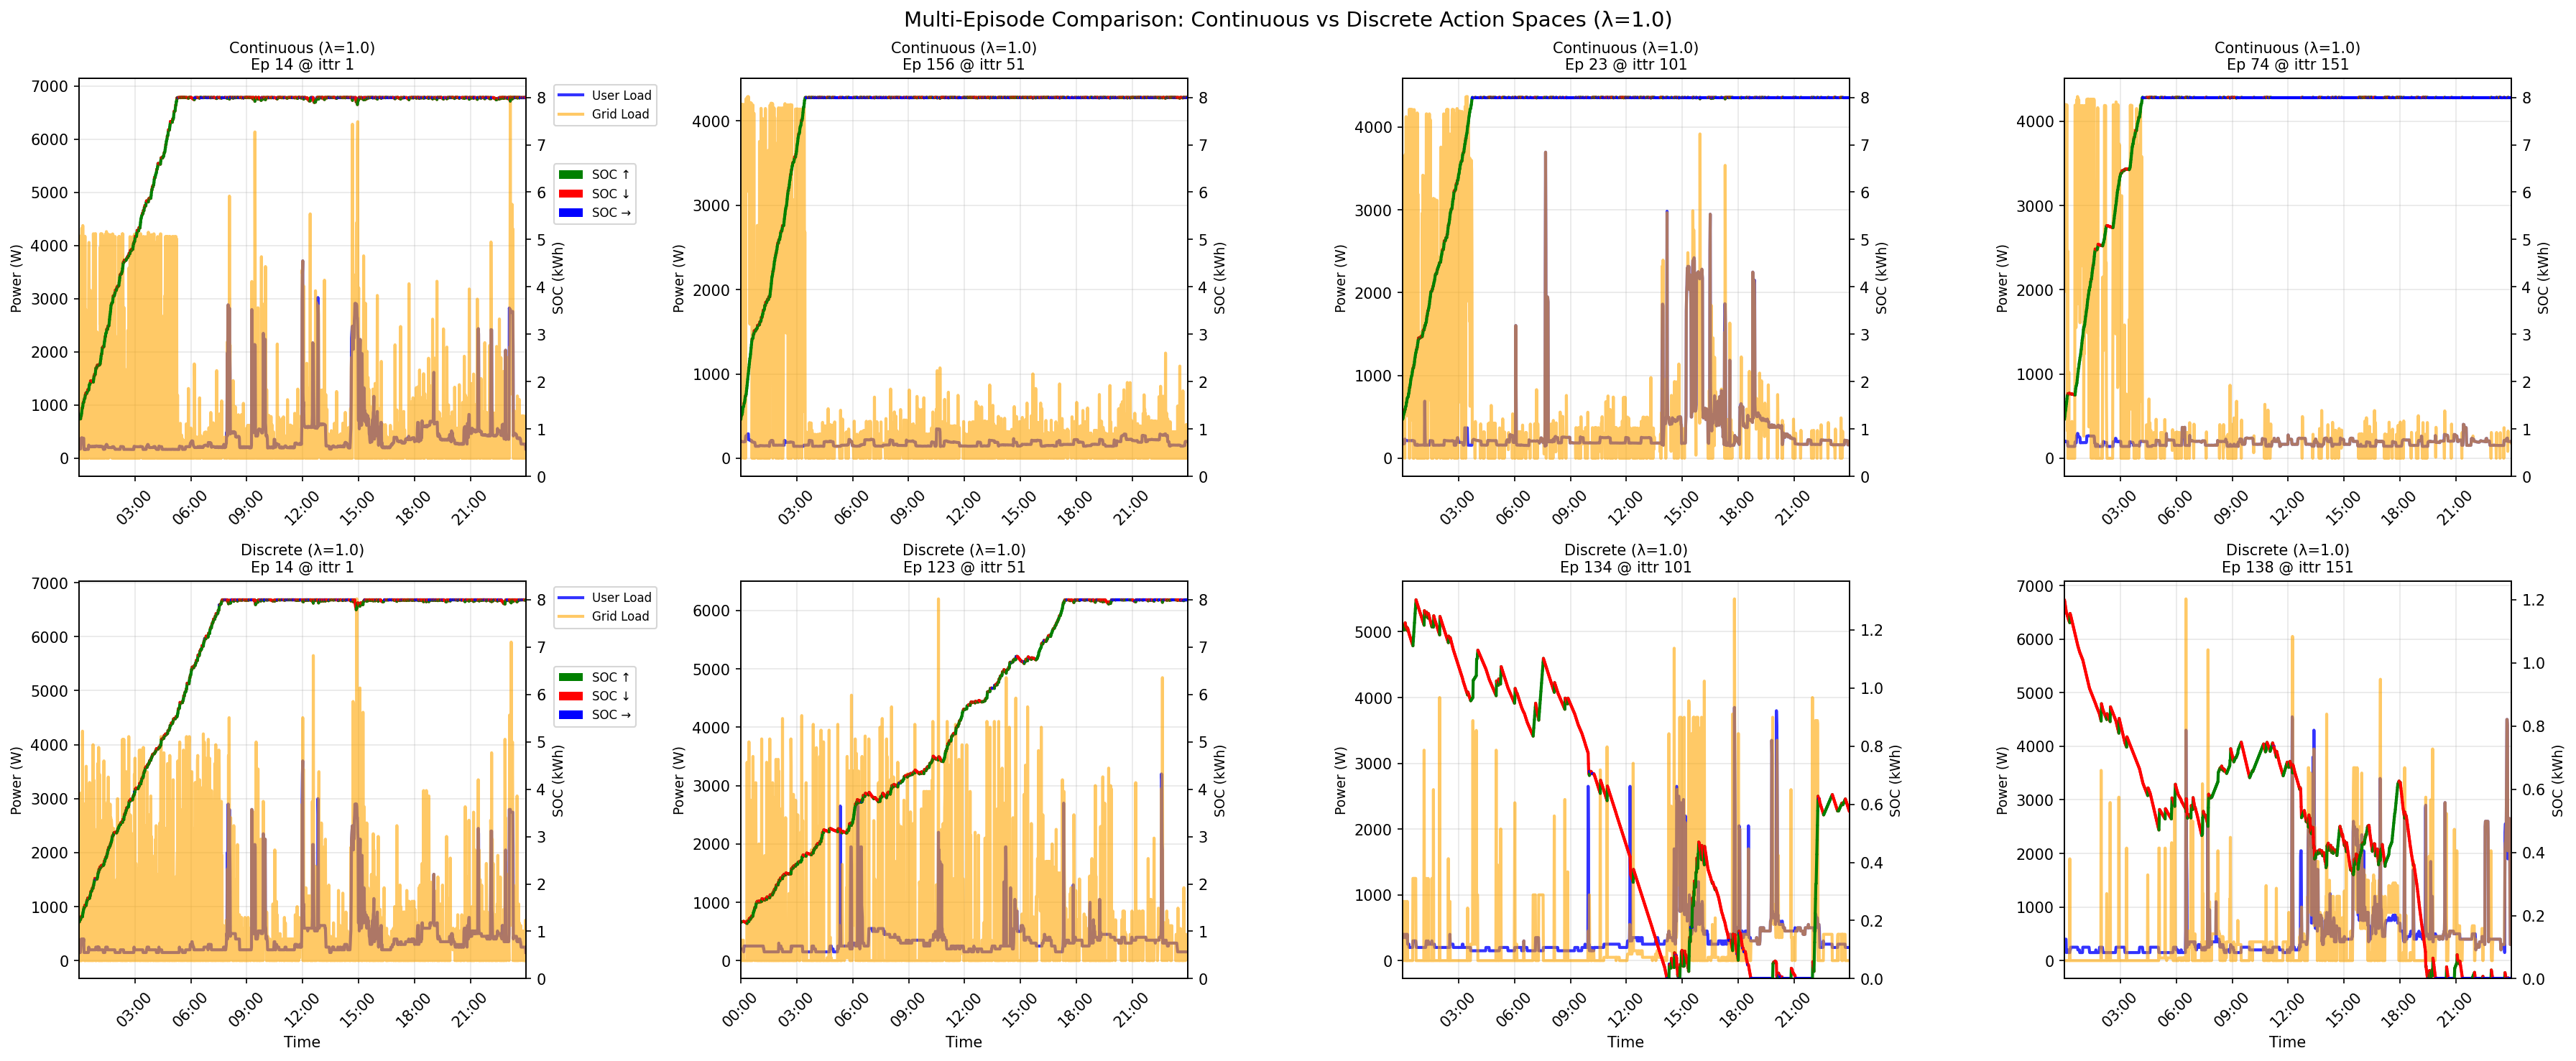

[2025-08-13 16:32:59:786] Demo plot generated successfully!


In [ ]:
# Demo: Generate a single comparison plot for λ = 1.0 first
print_log("Generating demo comparison plot for λ = 1.0...")

demo_fig, _ = plot_cross_action_space_episodes_grid(
    all_training_data=all_training_data,
    lambda_value="1.0",
    episode_interval=50,  # Plot every 50th episode  
    save_dir=output_folder,  # Use save_dir for auto-naming
    use_datetime=True,
    show=True,
    include_curriculum_info=True
)

if demo_fig is not None:
    print_log("Demo plot generated successfully!")
else:
    print_log("Demo plot generation failed - check data availability")

Multi-episode on different $\lambda$ value of the same action space

In [12]:
def plot_cross_lambda_episodes_grid(all_training_data, action_space, episode_interval=50, save_path=None, save_dir=None, use_datetime=False, show=True, include_curriculum_info=True):
    """
    Create a grid plot comparing episodes across different lambda values for the same action space.
    
    Args:
        all_training_data: Dictionary with keys (action_space, lambda_value) and values (episode_metadata_df, episode_info_dfs)
        action_space: String action space to compare (either "continuous" or "discrete")
        episode_interval: Interval between episodes to plot (default: 50)
        save_path: Optional specific path to save the figure (overrides auto-generated filename)
        save_dir: Directory to save the figure (used with auto-generated filename if save_path is None)
        use_datetime: Whether to use datetime for x-axis (default is False)
        show: Whether to display the plot
        include_curriculum_info: Whether to include curriculum information in titles
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    # Validate action space
    valid_action_spaces = ["continuous", "discrete"]
    if action_space not in valid_action_spaces:
        raise ValueError(f"action_space must be one of {valid_action_spaces}, got {action_space}")
    
    # Lambda values to compare
    lambda_values = ["0.0", "0.5", "1.0"]
    
    # Get data for all lambda values with the specified action space
    lambda_data = {}
    for lambda_val in lambda_values:
        key = (action_space, lambda_val)
        data = all_training_data.get(key)
        if data is None or data[1] is None:
            print_log(f"No data found for {action_space} action space with lambda={lambda_val}")
            return None
        lambda_data[lambda_val] = data
    
    # Determine episodes to plot based on interval
    min_episodes = min(len(episodes) for _, episodes in lambda_data.values())
    episode_indices = list(range(0, min_episodes, episode_interval))
    
    # Limit to reasonable number of subplots (max 4 episodes per row)
    if len(episode_indices) > 4:
        episode_indices = episode_indices[:4]
    
    n_episodes = len(episode_indices)
    if n_episodes == 0:
        print_log("No episodes to plot")
        return None
    
    print_log(f"Plotting {n_episodes} episodes at indices: {episode_indices}")
    print_log(f"Comparing lambda values: {lambda_values} for {action_space} action space")
    
    # Generate auto filename if save_path is not provided
    if save_path is None and save_dir is not None:
        episode_range = f"{episode_indices[0]:04d}_{episode_indices[-1]:04d}"
        filename = f"cross_lambda_episodes_{action_space}_episodes_{episode_range}_interval_{episode_interval}.png"
        save_path = save_dir / filename
        print_log(f"Auto-generated filename: {filename}")
    
    # Create figure with 3 rows (lambda values) and n_episodes columns
    fig, axes = plt.subplots(3, n_episodes, figsize=(6 * n_episodes, 12), dpi=150)
    
    # Handle single episode case
    if n_episodes == 1:
        axes = axes.reshape(3, 1)
    
    # Define colors and styling
    colors = {
        'user_load': 'blue',
        'grid_load': 'orange',
        'soc_increase': 'green',
        'soc_decrease': 'red',
        'soc_constant': 'blue'
    }
    
    for col_idx, episode_idx in enumerate(episode_indices):
        for row_idx, lambda_val in enumerate(lambda_values):
            ax = axes[row_idx, col_idx]
            metadata, episodes = lambda_data[lambda_val]
            episode_df = episodes[episode_idx]
            
            # Plot this lambda value's episode
            algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
            ax_twin = plot_single_episode(ax, episode_df, use_datetime, include_curriculum_info, 
                              metadata, f"{algo_name} λ={lambda_val}", colors, episode_idx)
            
            # Set x-axis label only for bottom row
            if row_idx == 2:  # Last row (lambda=1.0)
                if use_datetime and 'datetime' in episode_df.columns:
                    ax.set_xlabel('Time', fontsize=10)
                else:
                    ax.set_xlabel('Time Steps', fontsize=10)
            
            # Add legend only to first column
            if col_idx == 0:
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
                
                # Add SOC legend to first column using existing twin axis
                legend_elements = [Patch(facecolor='green', label='SOC ↑'),
                                 Patch(facecolor='red', label='SOC ↓'),
                                 Patch(facecolor='blue', label='SOC →')]
                ax_twin.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0.8), loc='upper left', fontsize=8)
    
    algo_name = "DDQL-MI" if action_space == "discrete" else "PPO-MI"
    plt.suptitle(f'Multi-Episode Comparison: {algo_name} Across Lambda Values', 
                 fontsize=14, y=0.98)
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print_log(f"Plot saved to: {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close(fig)
        plt.close('all')
    
    return fig

[2025-08-13 15:32:24:197] 
[2025-08-13 15:32:24:197] Generating lambda comparison plot for continuous action space
[2025-08-13 15:32:24:197] ======================================================================
[2025-08-13 15:32:24:197] Plotting 4 episodes at indices: [0, 50, 100, 150]
[2025-08-13 15:32:24:197] Comparing lambda values: ['0.0', '0.5', '1.0'] for continuous action space
[2025-08-13 15:32:26:319] Plot saved to: experiments_graphs/cross_lambda_episodes_continuous.png


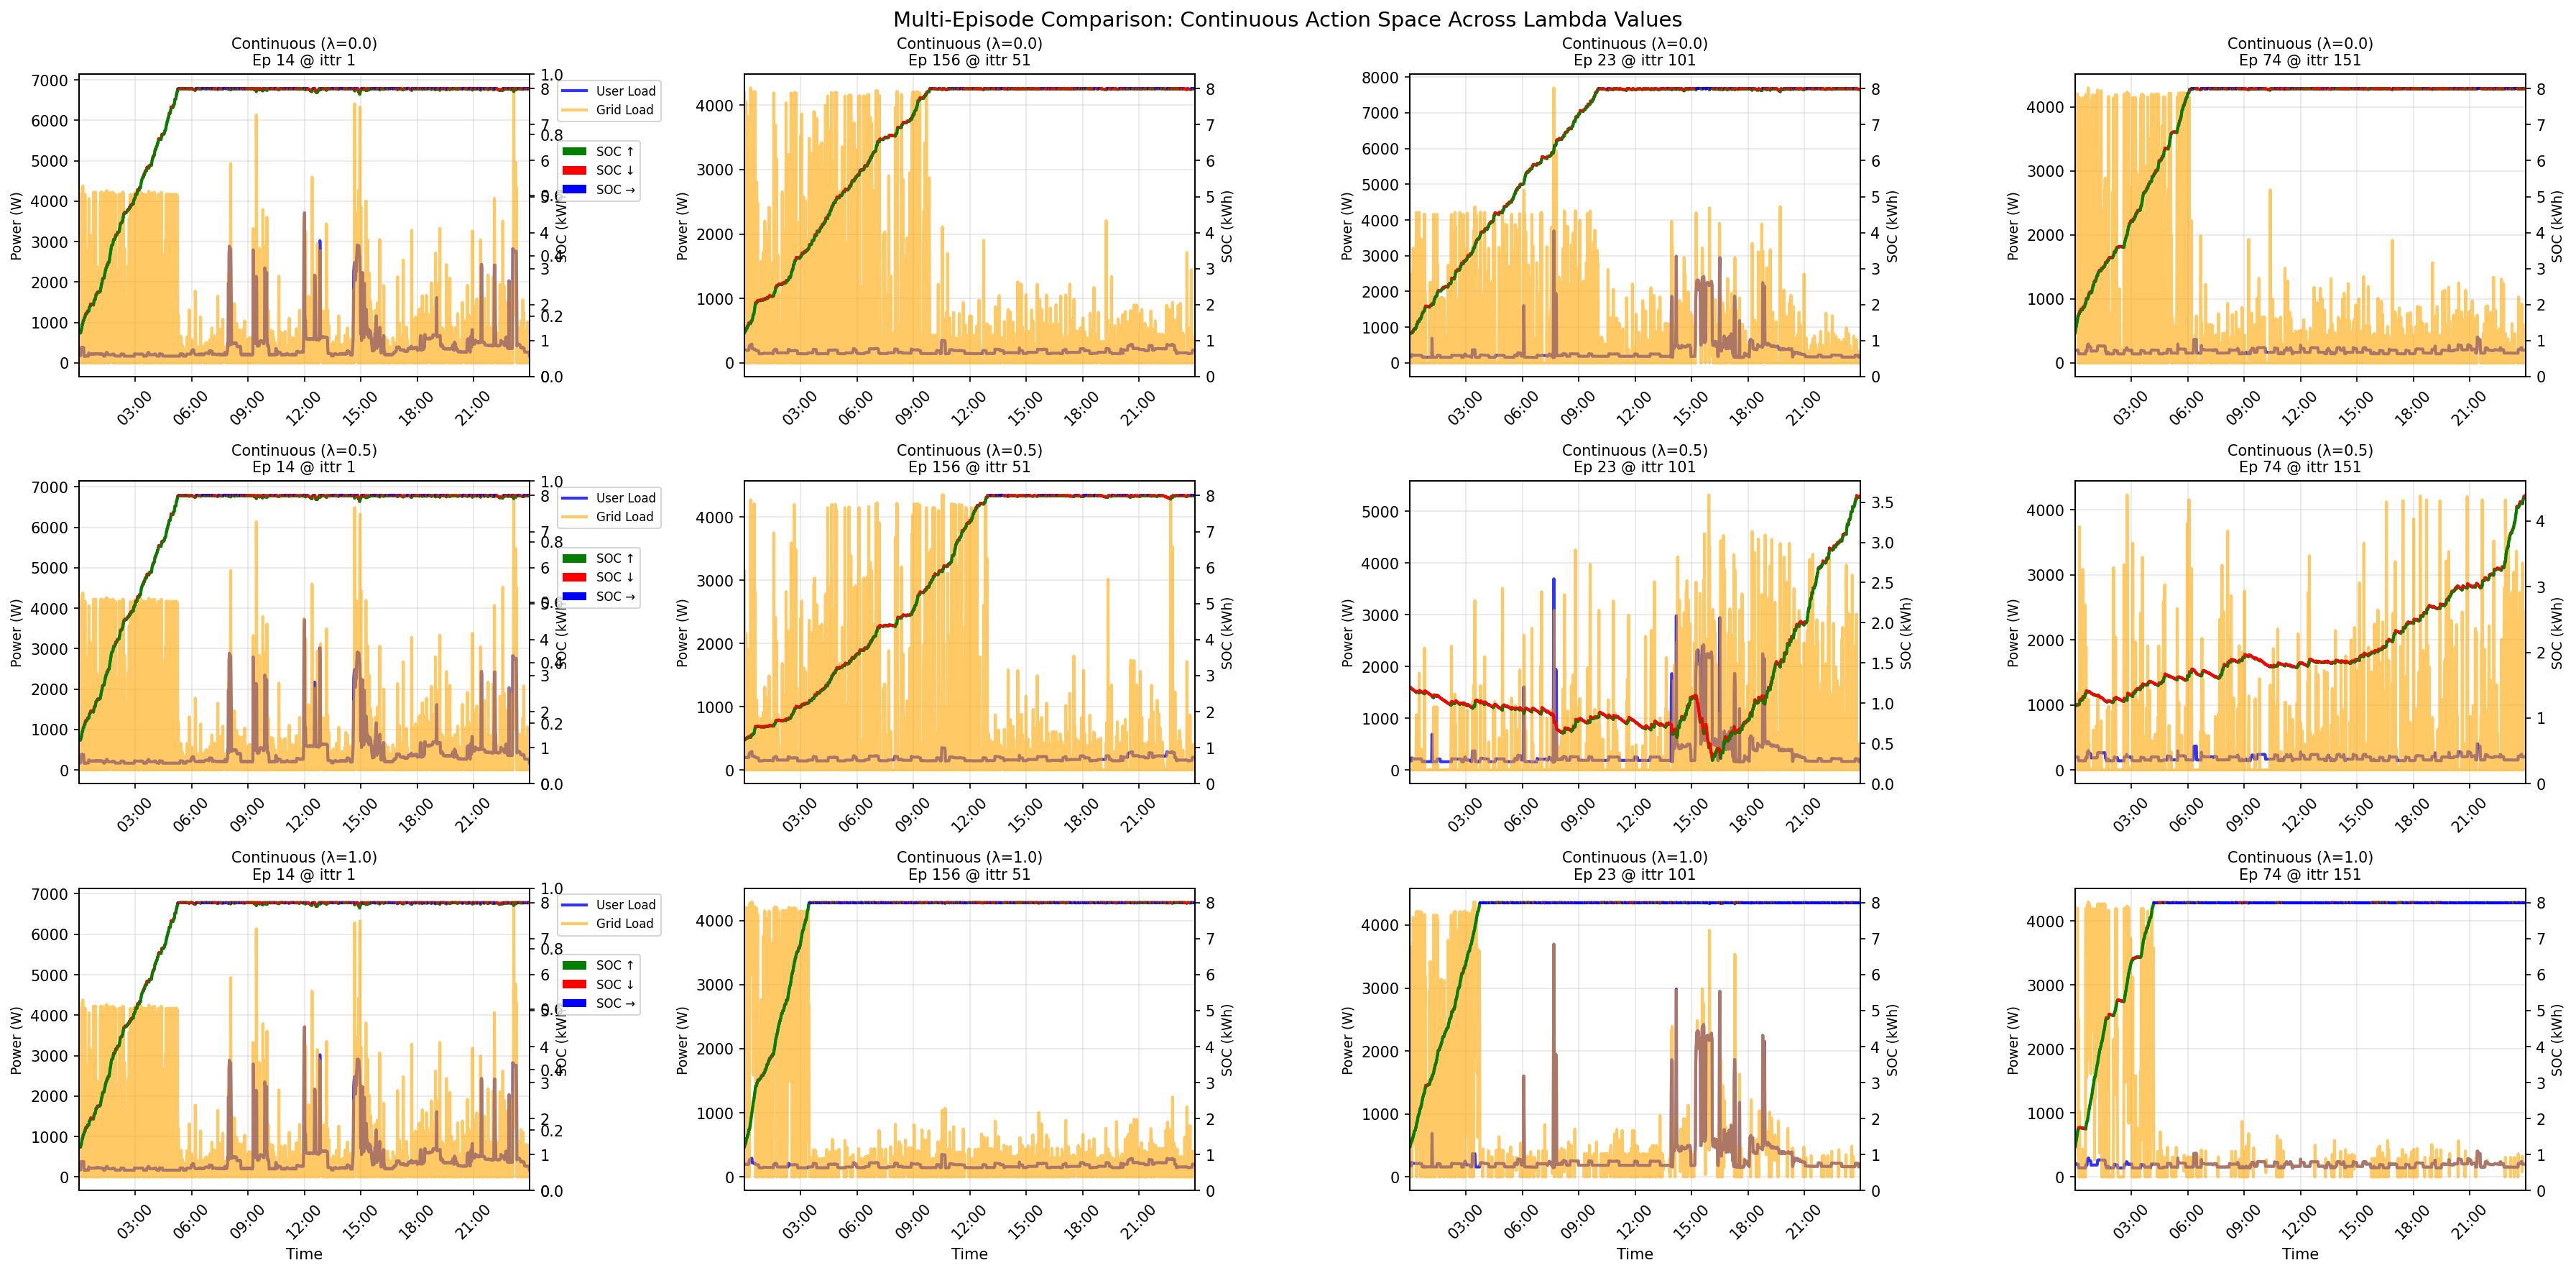

[2025-08-13 15:32:27:703] Successfully generated lambda comparison plot for continuous
[2025-08-13 15:32:27:703] Plot saved to: experiments_graphs/cross_lambda_episodes_continuous.png
[2025-08-13 15:32:27:703] ----------------------------------------------------------------------
[2025-08-13 15:32:27:703] 
[2025-08-13 15:32:27:703] Generating lambda comparison plot for discrete action space
[2025-08-13 15:32:27:703] ======================================================================
[2025-08-13 15:32:27:703] Plotting 4 episodes at indices: [0, 50, 100, 150]
[2025-08-13 15:32:27:703] Comparing lambda values: ['0.0', '0.5', '1.0'] for discrete action space
[2025-08-13 15:32:29:822] Plot saved to: experiments_graphs/cross_lambda_episodes_discrete.png


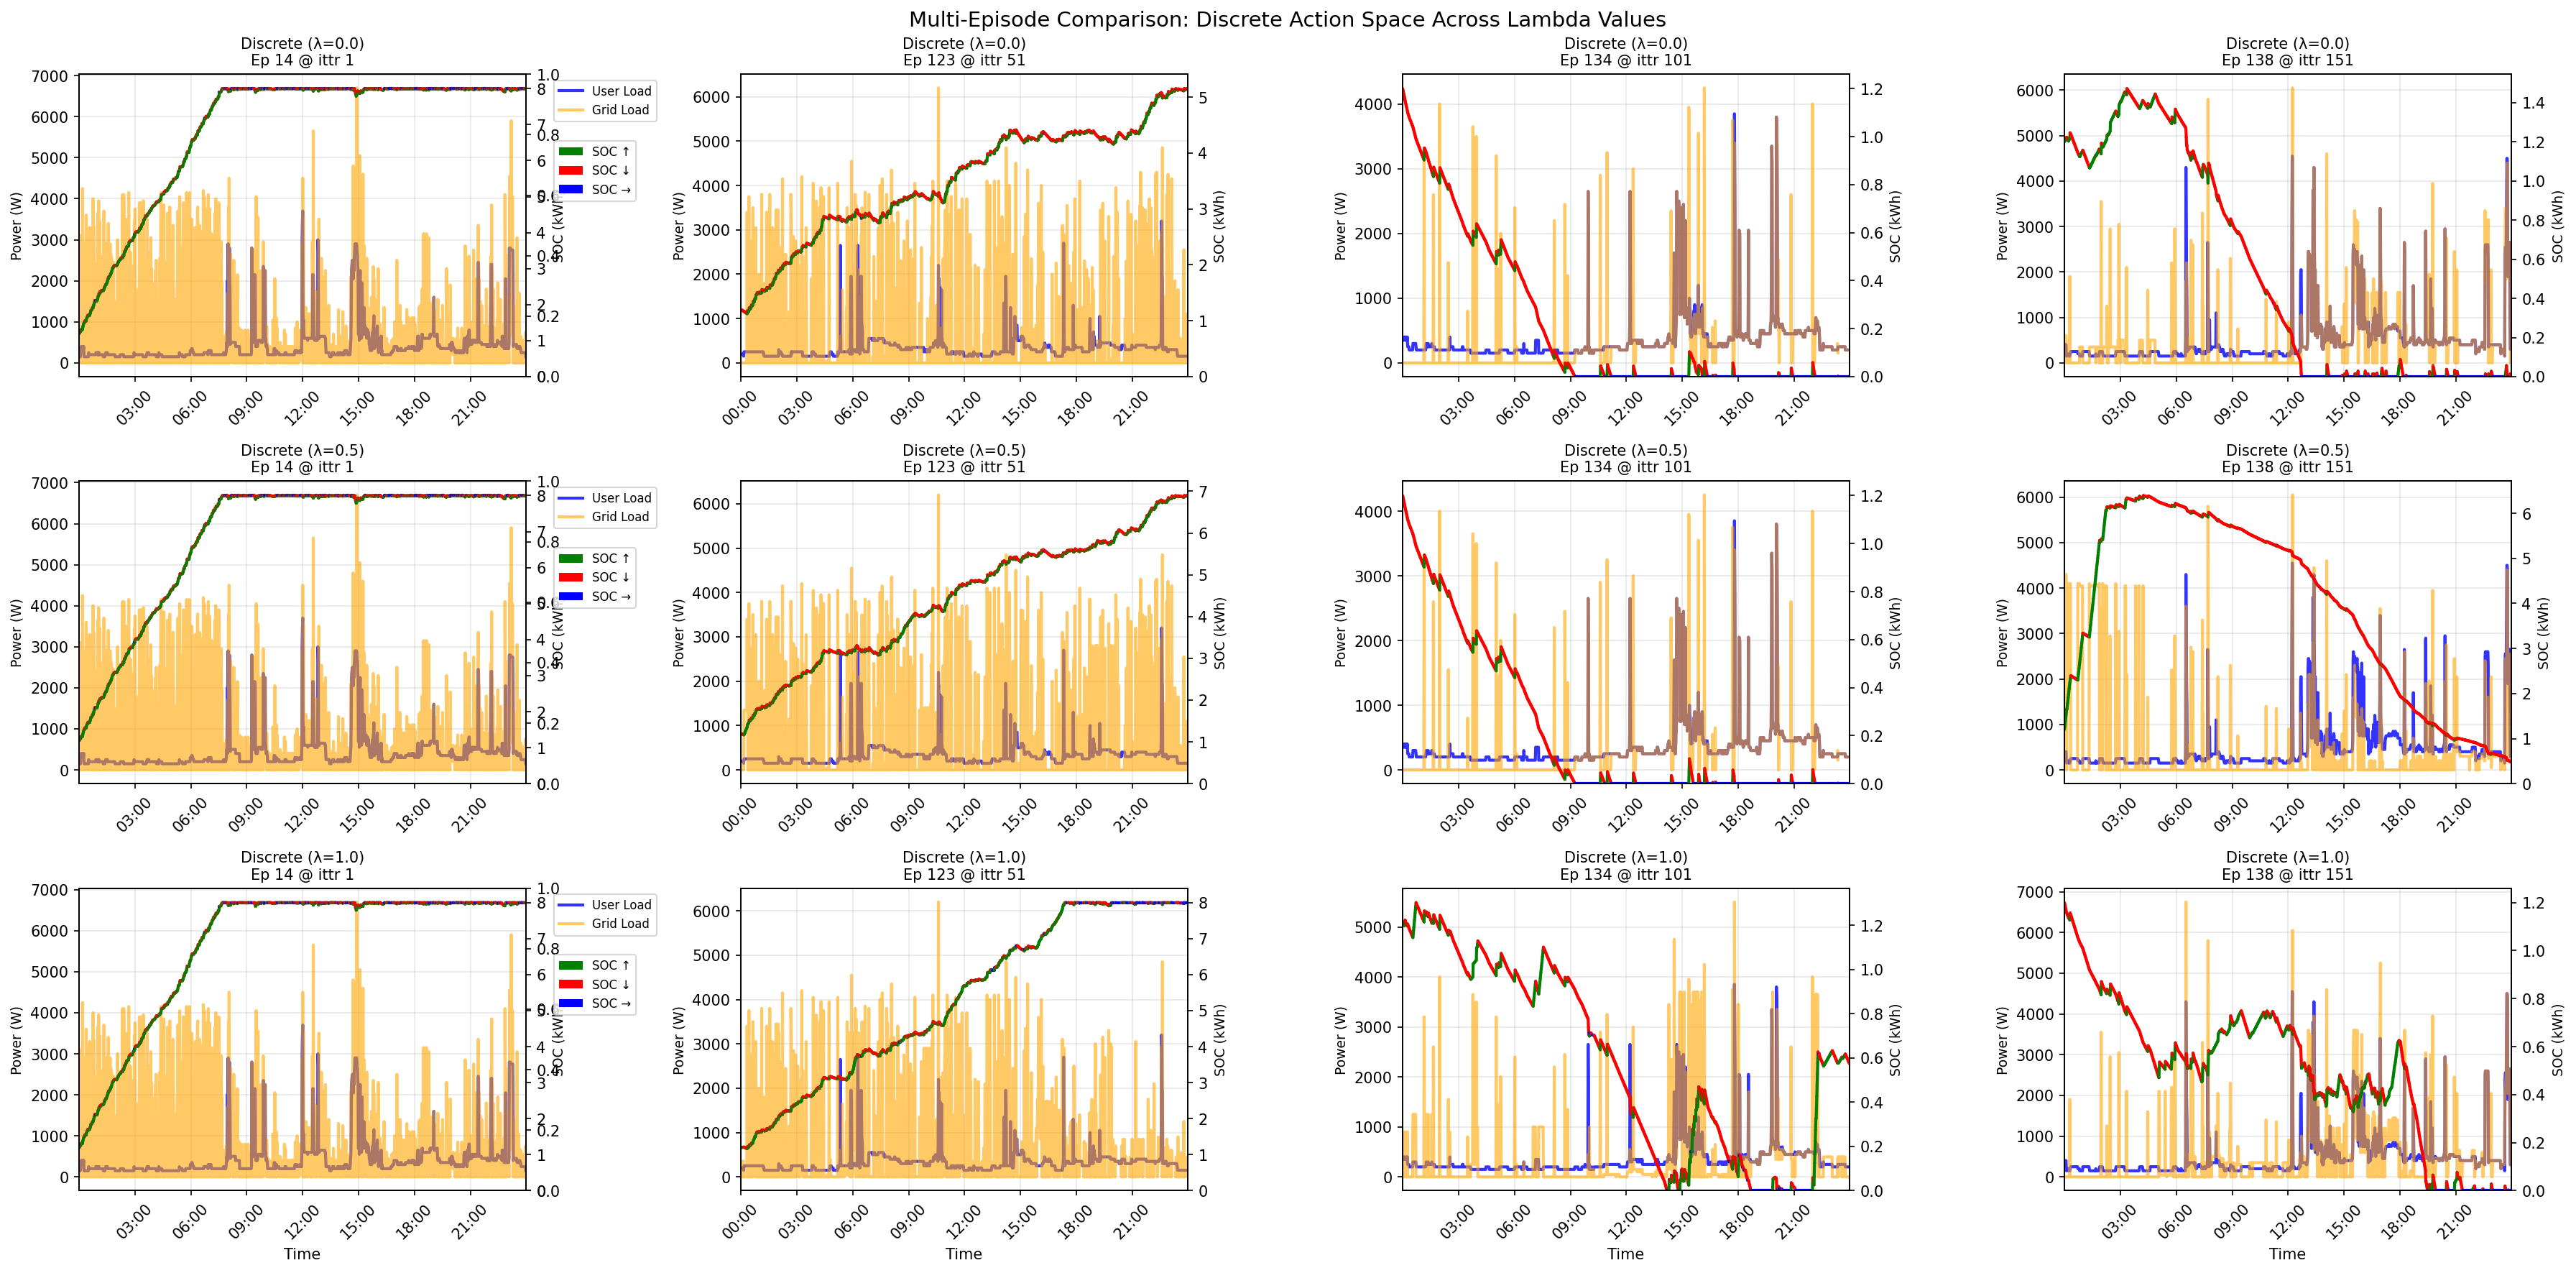

[2025-08-13 15:32:30:912] Successfully generated lambda comparison plot for discrete
[2025-08-13 15:32:30:913] Plot saved to: experiments_graphs/cross_lambda_episodes_discrete.png
[2025-08-13 15:32:30:913] ----------------------------------------------------------------------


In [ ]:
# Execute the cross-lambda comparison for both action spaces
action_spaces = ["continuous", "discrete"]

for action_space in action_spaces:
    print_log(f"\n{'='*70}")
    print_log(f"Generating lambda comparison plot for {action_space} action space")
    print_log(f"{'='*70}")
    
    # Generate the plot with auto-generated filename
    fig = plot_cross_lambda_episodes_grid(
        all_training_data=all_training_data,
        action_space=action_space,
        episode_interval=50,  # Plot every 50th episode
        save_dir=output_folder,  # Use save_dir instead of save_path for auto-naming
        use_datetime=True,    # Use datetime for x-axis
        show=True,           # Display the plot
        include_curriculum_info=True
    )
    
    if fig is not None:
        print_log(f"Successfully generated lambda comparison plot for {action_space}")
    else:
        print_log(f"Failed to generate plot for {action_space} - check data availability")
    
    print_log("-" * 70)

In [26]:
# Demo: Generate a focused lambda comparison plot for continuous action space only
print_log("Generating demo lambda comparison plot for continuous action space...")

demo_lambda_fig = plot_cross_lambda_episodes_grid(
    all_training_data=all_training_data,
    action_space="continuous",
    episode_interval=100,  # Plot every 100th episode for fewer comparisons
    save_dir=output_folder,  # Use save_dir for auto-naming
    use_datetime=True,
    show=False,  # Don't show to avoid duplicate display
    include_curriculum_info=True
)

if demo_lambda_fig is not None:
    print_log("Demo lambda comparison plot generated successfully!")
else:
    print_log("Demo lambda comparison plot generation failed")

[2025-08-13 15:51:35:870] Generating demo lambda comparison plot for continuous action space...
[2025-08-13 15:51:35:870] Plotting 4 episodes at indices: [0, 100, 200, 300]
[2025-08-13 15:51:35:870] Comparing lambda values: ['0.0', '0.5', '1.0'] for continuous action space
[2025-08-13 15:51:35:870] Auto-generated filename: cross_lambda_episodes_continuous_episodes_0000_0300_interval_100.png
[2025-08-13 15:51:38:337] Plot saved to: experiments_graphs/multi_episodes/cross_lambda_episodes_continuous_episodes_0000_0300_interval_100.png
[2025-08-13 15:51:38:338] Demo lambda comparison plot generated successfully!
[2025-08-13 15:51:38:337] Plot saved to: experiments_graphs/multi_episodes/cross_lambda_episodes_continuous_episodes_0000_0300_interval_100.png
[2025-08-13 15:51:38:338] Demo lambda comparison plot generated successfully!


## Enhanced Filename Generation

Both plotting functions now support automatic filename generation that includes:

### Auto-generated Filename Format:
- **Cross Action Space**: `cross_action_space_episodes_lambda_{λ}_episodes_{start}_{end}_interval_{interval}.png`
- **Cross Lambda**: `cross_lambda_episodes_{action_space}_episodes_{start}_{end}_interval_{interval}.png`

### Usage Options:
1. **Auto-naming** (recommended): Use `save_dir=output_folder` - generates descriptive filenames automatically
2. **Custom naming**: Use `save_path="custom/path/filename.png"` - overrides auto-generation
3. **No saving**: Omit both parameters to display only

### Benefits:
- **Descriptive filenames** that include episode range and interval information
- **Easy identification** of plot parameters from filename
- **Consistent naming** across different experiments
- **Automatic organization** in the output directory